In [6]:
import numpy as np
import matplotlib.pyplot as plt
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.euclidean import Euclidean

In [4]:
h = Hyperboloid(2)
s = Hypersphere(2)
e = Euclidean(3)

In [5]:
PT = True   # parallel transport

results = {}
results2 = {}
curvs = [.25, .5, .75, 1., 1.25]
origin = np.array([1., 0., 0.])

for manifold, sign in zip([h, s], [-1, 1]):
    for k in curvs:
        X_tangent = np.random.normal(size=(1_000_000, 2))

        # pre-adjust for curvature
        X_tangent *= np.sqrt(k)

        # prepend 0 to make it a tangent plane vector
        X_tangent = np.column_stack((np.zeros(X_tangent.shape[0]), X_tangent))

        if PT:
            # Sample a random point on the manifold
            mu = manifold.random_point()
            X_tangent = manifold.metric.parallel_transport(X_tangent, origin, end_point=mu)
        else:
            mu = origin

        # exp map at origin/PT origin
        X_manifold = manifold.metric.exp(X_tangent, mu)

        # Get distances to origin/PT origin
        dists = manifold.metric.dist(X_manifold, mu)

        # Make sure to rescale to get the distance in the manifold of correct curvature
        results[sign * k] = dists / np.sqrt(k)

        # Get distances the other way:
        # Here, we demonstrate that rescaling the manifold and computing the distance works the same as dividing the
        # distance in the original manifold by sqrt(k)
        X_rescaled = X_manifold / np.sqrt(k)
        mu_rescaled = mu / np.sqrt(k)
        assert np.allclose(manifold.metric.squared_norm(X_rescaled), sign / k) # <x, x> = +/- 1 / K after rescale
        if manifold is h:
            results2[sign * k] = np.arccosh(-k * manifold.metric.inner_product(X_rescaled, mu_rescaled)) / np.sqrt(k)
        else: # sphere
            results2[sign * k] = np.arccos(k * manifold.metric.inner_product(X_rescaled, mu_rescaled)) / np.sqrt(k)
        
        assert np.allclose(results[sign * k], results2[sign * k])

## Plot PDFs

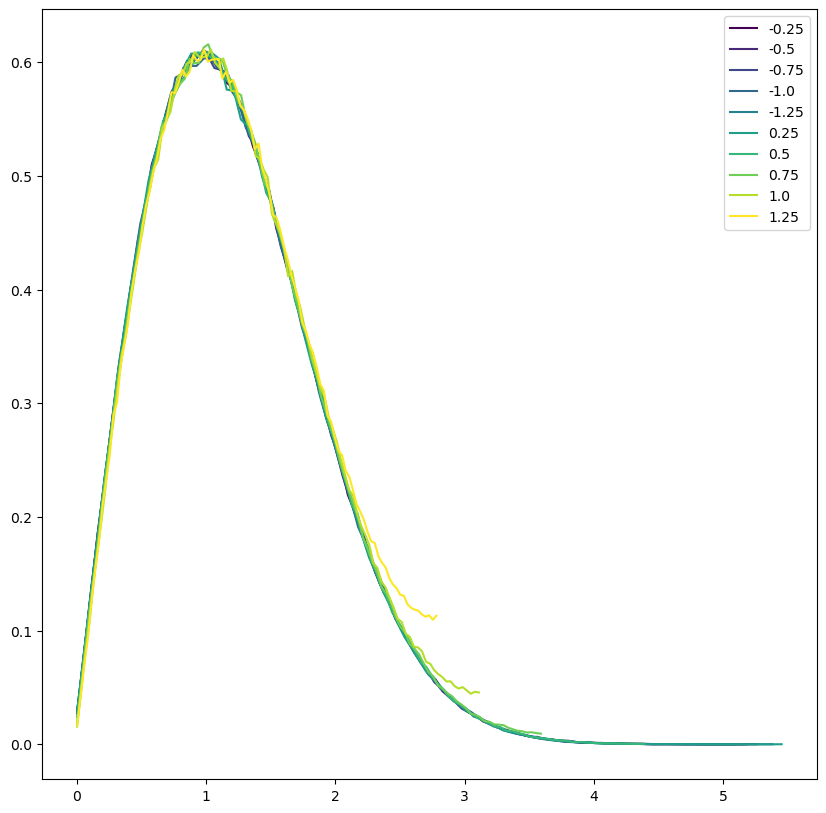

In [7]:
colors = plt.cm.viridis(np.linspace(0, 1, len(results)))

fig = plt.figure(figsize=(10, 10))

for i, (curvature, dists) in enumerate(results.items()):
    # Generate line graph of pdf
    dists = dists[~np.isnan(dists)]
    hist = np.histogram(dists, bins=100, density=True)
    plt.plot(hist[1][:-1], hist[0], label=f"{curvature}", color=colors[i])
plt.legend()

In [8]:
# Euclidean case
results[0] = results2[0] = np.linalg.norm(np.random.normal(size=(1_000_000, 2)), axis=1)